# Question 2 (probability of a positive asset return)

## Importing of libraries

In [1]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
from itertools import combinations 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
!pip install nbconvert

!pip install pyppeteer

## Reading of dataset

In [3]:
# converted italian date to english date format in excel dataset 
factors = pd.read_excel('data_coursework_Q2_edited.xls', sheet_name = 'final_m')
factors.head()

,mth,date,ESR,USR,EIF,ERECB,EFX,EDY,ESP,UIF,URR,UDY,UOIL
0,31-gen-85,1985-01-31,0.0559,0.0690,0.0209,1.6094,0.0025,1.1663,2.206,0.0396,2.1668,1.4951,0.0210
1,1985-02-28 00:00:00,1985-02-28,0.0331,0.0066,0.0235,1.6582,0.0556,1.1474,2.374,0.0347,2.1679,1.4929,0.0094
2,1985-03-31 00:00:00,1985-03-31,-0.0027,-0.0089,0.0249,1.6582,-0.0813,1.1474,2.142,0.0354,2.1494,1.5041,0.0582
3,1985-04-30 00:00:00,1985-04-30,0.0226,-0.0057,0.0250,1.6582,0.0049,1.1569,2.023,0.0372,2.1494,1.5173,-0.0269
4,31-mag-85,1985-05-31,0.0424,0.0504,0.0236,1.6582,-0.0127,1.1282,1.856,0.0352,2.0334,1.4679,0.0108


## Part a: estimation of linear regression model via OLS

I chose 2 separate models to study stock returns of the United States and Europe since they belong to separate economies.

I also chose all the factors given in the dataset as potential predictors for the stock returns with my justifications outlined below.

**Europe**\
Dividend yield (EDY): A high dividend yield normally means that stock prices today tend to be cheaper compared to their dividends, indicating high risk sentiment in the market. The risk premium is therefore higher and the market is expected to generate higher returns.\

Euro/dollar exchange rate (EFX): Currency movements capture the macroeconomic conditions of a country or countries within the similar region and market returns closely tie in with macroeconomic events.\

Inflation rate (EIF): If inflation is high, investors expect the central banks to increase interest rates and therefore cause prices in the stock marekt to decrease and hence lowers the returns.\

Rate level (ERECB): Historically, there is a negative correlation between market returns and the interest rate as lower interest rates allows investments and the cost of borrowing to be cheaper, thus increasing market returns.\

Term spread (ESP): The term spread is defined as the long-term yield minus short-term yield. WIth a wider term spread, investors are optimistic about the economy and expect short-term interest rates to rise and markets to grow, hence boosting stock returns. \

**US**\
Dividend yield (UDY): Same reasoning as the rate level for Europe's market returns.\

Inflation rate (UIF): Same reasoning as the rate level for Europe's market returns.\

Variation in oil price (t/t-1) (UOIL): If oil prices rise, this can lead to rise in inflation in the US economy which can cause the FED to increase interest rates. Companies that rely on oil can also see their profit margins decrease and hence a lower overall market return.\

Rate level (URR): Same reasoning as the rate level for Europe's market returns.

In [4]:
# Transform USR and ESR into indicator variables 
# Contruct indicator variables (Y) \ 
# where Y = 1 if return > 0 and Y = 0 if return <= 0
factors['Y_USR'] = np.where(factors['USR'] > 0, 1, 0)
factors['Y_ESR'] = np.where(factors['ESR'] > 0, 1, 0)

# Construct predictors (X) for USR and ESR
pred_USR = ['UDY','UIF','UOIL','URR']
X_USR = factors[pred_USR]

pred_ESR = ['EDY','EFX','EIF','ERECB','ESP']
X_ESR = factors[pred_ESR]

# add intercept term to linear regression model 
X_USR = sm.add_constant(X_USR)
X_ESR = sm.add_constant(X_ESR)

# Move indicator variables one time frame forward (i.e. Y_(t+1)) 
factors['Y_USR_forward'] = factors['Y_USR'].shift(-1)
factors['Y_ESR_forward'] = factors['Y_ESR'].shift(-1)

# remove both NA values of last row for indicator variables and \
# values of last row for predictors 
f_new = factors.drop(index=factors.index[-1])

# update variables for new dataframe 
f_new['Y_USR_forward'] = factors['Y_USR_forward'] 
f_new['Y_ESR_forward'] = factors['Y_ESR_forward']

# update predictor terms for new dataframe 
X_USR_new = f_new[pred_USR]
X_ESR_new = f_new[pred_ESR]

# add intercept terms for new dataframe
X_USR_new = sm.add_constant(X_USR_new)
X_ESR_new = sm.add_constant(X_ESR_new)

# Construct dependent variable for OLS python package 
Y_US = f_new['Y_USR_forward']
Y_EMU = f_new['Y_ESR_forward']

# linear regression model using OLS 
OLS_model_US = sm.OLS(Y_US,X_USR_new).fit()
OLS_model_EMU = sm.OLS(Y_EMU,X_ESR_new).fit()

### Results for US Market

In [5]:
print(OLS_model_US.summary()) 

                            OLS Regression Results                            
Dep. Variable:          Y_USR_forward   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     2.757
Date:                Sun, 23 Nov 2025   Prob (F-statistic):             0.0282
Time:                        17:01:43   Log-Likelihood:                -198.63
No. Observations:                 290   AIC:                             407.3
Df Residuals:                     285   BIC:                             425.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6161      0.092      6.682      0.0

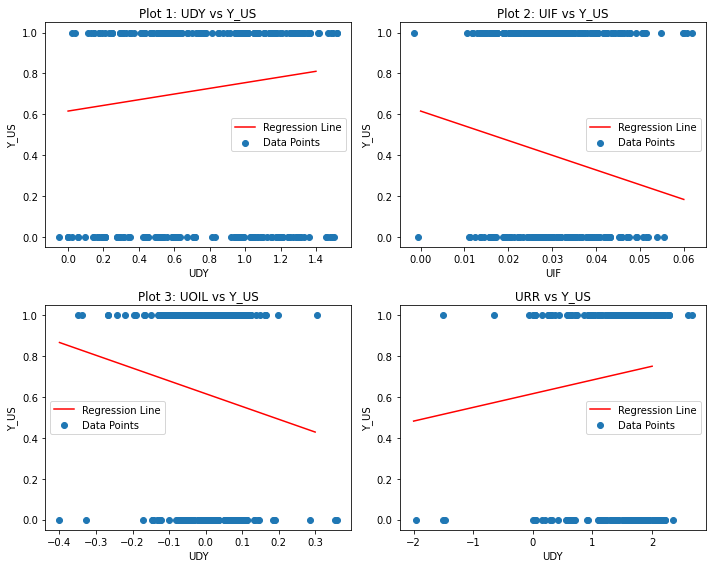

In [6]:
# plot a scatter graph for predictors vs indicator variables
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# data for plotting of linear regression line
x1_plot = np.linspace(0,1.4,100)
x2_plot = np.linspace(0,0.06,100)
x3_plot = np.linspace(-0.4,0.3,100)
x4_plot = np.linspace(-2,2,100)

y1_plot = x1_plot*OLS_model_US.params[1] + OLS_model_US.params[0]
y2_plot = x2_plot*OLS_model_US.params[2] + OLS_model_US.params[0]
y3_plot = x3_plot*OLS_model_US.params[3] + OLS_model_US.params[0]
y4_plot = x4_plot*OLS_model_US.params[4] + OLS_model_US.params[0]

# first plot 
ax[0,0].scatter(f_new['UDY'], Y_US, label='Data Points') 
ax[0,0].plot(x1_plot, y1_plot, color='red', label='Regression Line') 
ax[0,0].set_title('Plot 1: UDY vs Y_US')
ax[0,0].set_xlabel('UDY')
ax[0,0].set_ylabel('Y_US')
ax[0,0].legend()

# second plot 
ax[0,1].scatter(f_new['UIF'], Y_US, label='Data Points') 
ax[0,1].plot(x2_plot, y2_plot, color='red', label='Regression Line') 
ax[0,1].set_xlabel('UIF')
ax[0,1].set_ylabel('Y_US')
ax[0,1].set_title('Plot 2: UIF vs Y_US')
ax[0,1].legend()

# third plot 
ax[1,0].scatter(f_new['UOIL'], Y_US, label='Data Points') 
ax[1,0].plot(x3_plot, y3_plot, color='red', label='Regression Line') 
ax[1,0].set_title('Plot 3: UOIL vs Y_US')
ax[1,0].set_xlabel('UDY')
ax[1,0].set_ylabel('Y_US')
ax[1,0].legend()

# fourth plot 
ax[1,1].scatter(f_new['URR'], Y_US, label='Data Points') 
ax[1,1].plot(x4_plot, y4_plot, color='red', label='Regression Line') 
ax[1,1].set_title('URR vs Y_US')
ax[1,1].set_xlabel('UDY')
ax[1,1].set_ylabel('Y_US')
ax[1,1].legend()

plt.tight_layout()
plt.savefig('high_quality_plot.png', dpi=300) 
plt.show()

### Results for Eurozone Market

In [7]:
print(OLS_model_EMU.summary())

                            OLS Regression Results                            
Dep. Variable:          Y_ESR_forward   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.5243
Date:                Sun, 23 Nov 2025   Prob (F-statistic):              0.758
Time:                        17:01:44   Log-Likelihood:                -205.12
No. Observations:                 290   AIC:                             422.2
Df Residuals:                     284   BIC:                             444.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6964      0.190      3.665      0.0

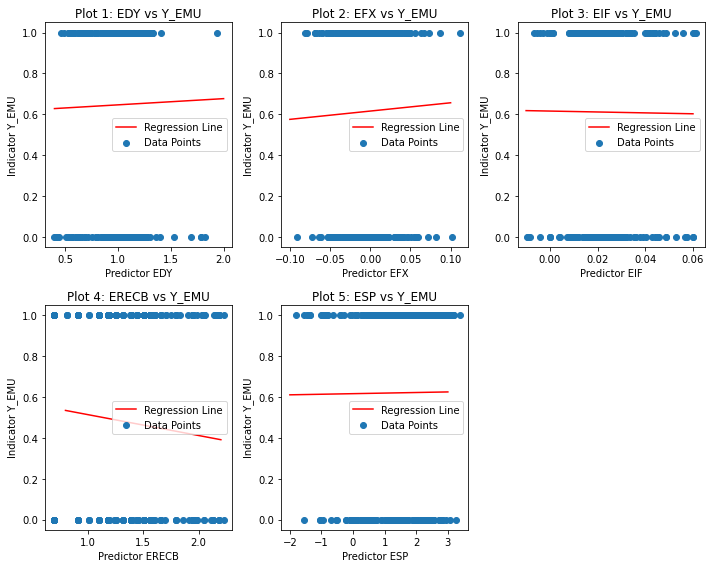

In [8]:
## EMU plots ##
# plot a scatter graph for predictors vs indicator variables
fig, ax = plt.subplots(2, 3, figsize=(10, 8))

# data for plotting of linear regression line
x1_plot = np.linspace(0.4,2,100)
x2_plot = np.linspace(-0.1,0.1,100)
x3_plot = np.linspace(-0.01,0.06,100)
x4_plot = np.linspace(0.8,2.2,100)
x5_plot = np.linspace(-2,3,100)

y1_plot = x1_plot*OLS_model_EMU.params[1] + OLS_model_US.params[0]
y2_plot = x2_plot*OLS_model_EMU.params[2] + OLS_model_US.params[0]
y3_plot = x3_plot*OLS_model_EMU.params[3] + OLS_model_US.params[0]
y4_plot = x4_plot*OLS_model_EMU.params[4] + OLS_model_US.params[0]
y5_plot = x5_plot*OLS_model_EMU.params[5] + OLS_model_US.params[0]

# first plot 
ax[0,0].scatter(f_new['EDY'], Y_EMU, label='Data Points') 
ax[0,0].plot(x1_plot, y1_plot, color='red', label='Regression Line') 
ax[0,0].set_title('Plot 1: EDY vs Y_EMU')
ax[0,0].set_xlabel('Predictor EDY')
ax[0,0].set_ylabel('Indicator Y_EMU')
ax[0,0].legend()

# second plot 
ax[0,1].scatter(f_new['EFX'], Y_EMU, label='Data Points') 
ax[0,1].plot(x2_plot, y2_plot, color='red', label='Regression Line') 
ax[0,1].set_title('Plot 2: EFX vs Y_EMU')
ax[0,1].set_xlabel('Predictor EFX')
ax[0,1].set_ylabel('Indicator Y_EMU')
ax[0,1].legend()

# third plot 
ax[0,2].scatter(f_new['EIF'], Y_EMU, label='Data Points') 
ax[0,2].plot(x3_plot, y3_plot, color='red', label='Regression Line') 
ax[0,2].set_title('Plot 3: EIF vs Y_EMU')
ax[0,2].set_xlabel('Predictor EIF')
ax[0,2].set_ylabel('Indicator Y_EMU')
ax[0,2].legend()

# fourth plot 
ax[1,0].scatter(f_new['ERECB'], Y_EMU, label='Data Points') 
ax[1,0].plot(x4_plot, y4_plot, color='red', label='Regression Line') 
ax[1,0].set_title('Plot 4: ERECB vs Y_EMU')
ax[1,0].set_xlabel('Predictor ERECB')
ax[1,0].set_ylabel('Indicator Y_EMU')
ax[1,0].legend()

# fifth plot 
ax[1,1].scatter(f_new['ESP'], Y_EMU, label='Data Points') 
ax[1,1].plot(x5_plot, y5_plot, color='red', label='Regression Line') 
ax[1,1].set_title('Plot 5: ESP vs Y_EMU')
ax[1,1].set_xlabel('Predictor ESP')
ax[1,1].set_ylabel('Indicator Y_EMU')
ax[1,1].legend()

# ignore sixth plot 
ax[1, 2].axis('off')

plt.tight_layout()
plt.savefig('high_quality_plot.png', dpi=300) 
plt.show()

**Analysis**:\
From our plots, we can tell that the OLS method is very bad at modelling binary outputs. For further and more accurate studies, a logistic regression may be a better representation instead.   

## Part b: Combination of predictors that gives the best performance

### US Market

In [21]:
# create empty list to store final results 
final_result = []

# function to find maximum value of Z(alpha)
def max_Z_finder(f_new, Y_US, pred_USR, alpha = 0.5):
    
    # find all predictors combinations starting from 1 
    for i in range(1, len(pred_USR)+1):
        for combos in combinations(pred_USR, i):
            predictors = list(combos)
            X_ols = f_new[predictors]
            X_ols = sm.add_constant(X_ols)
            
            OLS_model = sm.OLS(Y_US, X_ols).fit()
            
            # estimated probabilities of US stock total excess return 
            estimate_USR = OLS_model.fittedvalues
            
            # construct hit ratio indicator Z 
            rule_1 = (estimate_USR > alpha) & (Y_US == 1)
            rule_2 = (estimate_USR <= alpha) & (Y_US == 0)
            
            # combining rules together to get Z_t 
            Z_t = np.where(rule_1 | rule_2, 1, 0)
            
            # find average Z 
            Z = sum(Z_t)/(len(f_new['Y_USR_forward']))
            
            final_result.append((combos, Z))
            
    return final_result

final_solution_US = max_Z_finder(f_new, Y_US, pred_USR, alpha=0.5)

# Convert final_solution into DataFrame
result_US = pd.DataFrame(final_solution_US, columns=["Predictor Combinations", "Z(alpha)"])

# Sort returns
result_US = table_result.sort_values("Z(alpha)", ascending=False).reset_index(drop=True)

# top 5 results 
result_US.head(5)

,Predictor Combinations,Z(alpha)
0,"(UDY, UIF, UOIL)",0.634483
1,"(UDY, UIF, URR)",0.627586
2,"(UDY, UIF)",0.624138
3,"(UDY, UOIL)",0.617241
4,"(UIF, UOIL)",0.613793


We can see that the UDY, UIF, and UOIL combination had the maximum Z(alpha) value.

### Eurozone Market

In [23]:
# create empty list to store final results 
final_result = []

# function to find maximum value of Z(alpha)
def max_Z_finder(f_new, Y_EMU, pred_ESR, alpha = 0.5):
    
    # find all predictors combinations starting from 1 
    for i in range(1, len(pred_ESR)+1):
        for combos in combinations(pred_ESR, i):
            predictors = list(combos)
            X_ols = f_new[predictors]
            X_ols = sm.add_constant(X_ols)
            
            OLS_model = sm.OLS(Y_EMU, X_ols).fit()
            
            # estimated probabilities of Europe stock total excess return 
            estimate_ESR = OLS_model.fittedvalues
            
            # construct hit ratio indicator Z 
            rule_1 = (estimate_ESR > alpha) & (Y_EMU == 1)
            rule_2 = (estimate_ESR <= alpha) & (Y_EMU == 0)
            
            # combining rules together to get Z_t 
            Z_t = np.where(rule_1 | rule_2, 1, 0)
            
            # find average Z 
            Z = sum(Z_t)/(len(f_new['Y_ESR_forward']))
            
            final_result.append((combos, Z))
            
    return final_result

final_solution_EMU = max_Z_finder(f_new, Y_EMU, pred_ESR, alpha=0.5)

# Convert final_solution into DataFrame
result_EMU = pd.DataFrame(final_solution_EMU, columns=["Predictor Combinations", "Z(alpha)"])

# Sort returns
result_EMU = table_result.sort_values("Z(alpha)", ascending=False).reset_index(drop=True)

# top 5 results 
result_EMU.head(5)

,Predictor Combinations,Z(alpha)
0,"(EDY, EFX, ERECB)",0.596552
1,"(EFX, EIF)",0.589655
2,"(EDY, EFX, ERECB, ESP)",0.589655
3,"(EDY, EFX, EIF, ERECB)",0.589655
4,"(EDY, EFX, EIF, ERECB, ESP)",0.589655


We can see that the EDY, EFX, and ERECB combination had the maximum Z(alpha) value.

## Part c: Value of alpha to maximize Z(alpha)

### US Market

In [51]:
# create new array for predictor variables from part (b)
pred_new = ['UDY', 'UIF', 'UOIL']

# define function to find the best alpha 
def maximize_Z(f_new, Y_US, pred_new):
    
    # create empty list to store results
    result = []

    # alpha must be more than 0 and less than 1
    for alpha in np.linspace(1e-10,1,100):
        
        # new predictors from part (b)
        X_new = f_new[pred_new]
        X_new = sm.add_constant(X_new)
        
        OLS_model = sm.OLS(Y_US, X_new).fit()
            
        # estimated probabilities of US stock total excess return 
        estimate_USR = OLS_model.fittedvalues
        
        # construct hit ratio indicator Z 
        rule_1 = (estimate_USR > alpha) & (Y_US == 1)
        rule_2 = (estimate_USR <= alpha) & (Y_US == 0)
            
        # combining rules together to get Z_t 
        Z_t = np.where(rule_1 | rule_2, 1, 0)
            
        Z = sum(Z_t)/(len(f_new['Y_USR_forward']))
        
        result.append((Z, alpha))
                      
    return result 

US_sol = maximize_Z(f_new, Y_US, pred_new)

# Convert final_solution into DataFrame
US_c = pd.DataFrame(US_sol, columns=["Z(alpha)", "alpha"])

# Sort returns
US_c = US_c.sort_values("Z(alpha)", ascending=False).reset_index(drop=True)

# top 5 results 
US_c.head(5)

,Z(alpha),alpha
0,0.655172,0.555556
1,0.648276,0.565657
2,0.637931,0.505051
3,0.637931,0.535354
4,0.637931,0.525253


The best alpha which maximizes Z(alpha) is 0.556.

### Eurozone Market

In [50]:
# create new array for predictor variables from part (b)
pred_new = ['EDY', 'EFX', 'ERECB']

# define function to find the best alpha 
def maximize_Z(f_new, Y_EMU, pred_new):
    
    # create empty list to store results
    result = []

    # alpha must be more than 0 and less than 1
    for alpha in np.linspace(1e-10,1,1000):
        
        # new predictors from part (b)
        X_new = f_new[pred_new]
        X_new = sm.add_constant(X_new)
        
        OLS_model = sm.OLS(Y_EMU, X_new).fit()
            
        # estimated probabilities of Europe stock total excess return 
        estimate_ESR = OLS_model.fittedvalues
        
        # construct hit ratio indicator Z 
        rule_1 = (estimate_ESR > alpha) & (Y_EMU == 1)
        rule_2 = (estimate_ESR <= alpha) & (Y_EMU == 0)
            
        # combining rules together to get Z_t 
        Z_t = np.where(rule_1 | rule_2, 1, 0)
            
        Z = sum(Z_t)/(len(f_new['Y_ESR_forward']))
        
        result.append((Z, alpha))
                      
    return result 

EMU_sol = maximize_Z(f_new, Y_EMU, pred_new)

# Convert final_solution into DataFrame
EMU_c = pd.DataFrame(EMU_sol, columns=["Z(alpha)", "alpha"])

# Sort returns
EMU_c = EMU_c.sort_values("Z(alpha)", ascending=False).reset_index(drop=True)

# top 5 results 
EMU_c.head(5)

,Z(alpha),alpha
0,0.600000,0.500501
1,0.596552,0.499499
2,0.596552,0.501502
3,0.593103,0.516517
4,0.593103,0.515516


The best alpha which maximizes Z(alpha) is 0.5005.